In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto
from scipy.optimize import minimize
import seaborn as sns
import scipy.stats as ss


# Set seed 
np.random.seed(42)

## Detrending and Smoothing a Time Series

In [ ]:
df = pd.read_csv('df_fuel_ckan.csv')

# Convert the DATETIME column to datetime format
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Set the DATETIME column as the index
df.set_index('DATETIME', inplace=True)
# Resample to daily data
df_daily = df.resample('D').sum()

# Create a time index and extract day-of-year for seasonal indicators
df_daily['t'] = np.arange(len(df_daily))
df_daily['dayofyear'] = df_daily.index.dayofyear

# Define seasonal indicators based on day-of-year:
df_daily['summer'] = ((df_daily['dayofyear'] >= 150) & (df_daily['dayofyear'] <= 240)).astype(int)
df_daily['autumn'] = ((df_daily['dayofyear'] > 240) & (df_daily['dayofyear'] <= 330)).astype(int)
df_daily['winter'] = ((df_daily['dayofyear'] > 330) | (df_daily['dayofyear'] <= 60)).astype(int)
# Spring is the baseline
df_daily['spring'] = 1 - (df_daily['summer'] + df_daily['autumn'] + df_daily['winter'])

In [ ]:
# Detrend the data by subtracting the mean of each day-of-year
# Define a window (30 days) for the rolling average
window = 30

# Calculate the rolling average of the 'RENEWABLE' data
df_daily['trend'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).mean()

# Detrend by subtracting the rolling average from the original data
df_daily['detrended'] = df_daily['RENEWABLE'] - df_daily['trend']

df_daily['rolling_mean'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).mean()
df_daily['rolling_std'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).std()

# Standardize the data
df_daily['std_detrended'] = (df_daily['RENEWABLE'] - df_daily['rolling_mean']) / df_daily['rolling_std']

# Fit a Generalized Pareto Distribution (GPD) to the standardized detrended data
X = df_daily['std_detrended'].values
t = df_daily['t'].values
summer = df_daily['summer'].values
autumn = df_daily['autumn'].values
winter = df_daily['winter'].values
spring = df_daily['spring'].values

u  = np.quantile(X, 0.975)
mask = X > u


In [4]:
res = df_daily['std_detrended'].dropna()
print(f"Mean residual = {res.mean():.3f},   Std residual = {res.std():.3f}")


Mean residual = -0.003,   Std residual = 0.960


## Overview of the Generation Mix

Mean Daily Generation    = 34544.4 MW (σ=4776.2 MW)
Mean Daily Carbon Intensity = 303.3 gCO₂/kWh

Renewable share: 2.3% → 34.5%
Fossil     share: 73.8% → 25.2%
Nuclear    share: 20.6% → 14.7%



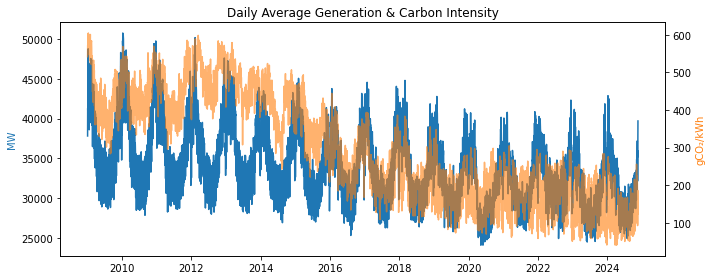

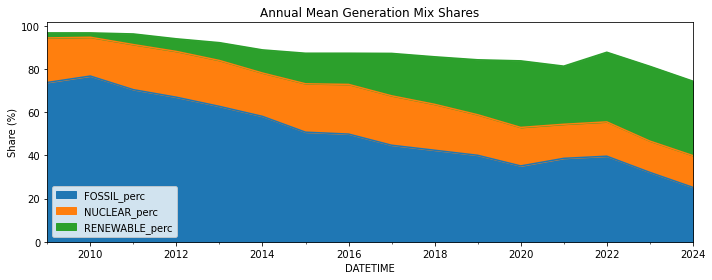

In [ ]:

df_day_avg = df.resample('D').mean()

mean_gen = df_day_avg['GENERATION'].mean()
std_gen  = df_day_avg['GENERATION'].std()
mean_ci  = df_day_avg['CARBON_INTENSITY'].mean()

print(f"Mean Daily Generation    = {mean_gen:.1f} MW (σ={std_gen:.1f} MW)")
print(f"Mean Daily Carbon Intensity = {mean_ci:.1f} gCO₂/kWh\n")

# Annual mean shares of Fossil / Nuclear / Renewables
annual = df_day_avg.resample('A').mean()[['FOSSIL_perc','NUCLEAR_perc','RENEWABLE_perc']]
start, end = annual.iloc[0], annual.iloc[-1]
print(f"Renewable share: {start.RENEWABLE_perc:.1f}% → {end.RENEWABLE_perc:.1f}%")
print(f"Fossil     share: {start.FOSSIL_perc:.1f}% → {end.FOSSIL_perc:.1f}%")
print(f"Nuclear    share: {start.NUCLEAR_perc:.1f}% → {end.NUCLEAR_perc:.1f}%\n")

# Plotting
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(df_day_avg.index, df_day_avg['GENERATION'], 'C0', label='Avg Daily Generation')
ax1.set_ylabel('MW', color='C0')
ax2 = ax1.twinx()
ax2.plot(df_day_avg.index, df_day_avg['CARBON_INTENSITY'], 'C1', alpha=0.6, label='Avg Daily Carbon Intensity')
ax2.set_ylabel('gCO₂/kWh', color='C1')
ax1.set_title('Daily Average Generation & Carbon Intensity')
fig.tight_layout()
plt.show()

annual[['FOSSIL_perc','NUCLEAR_perc','RENEWABLE_perc']].plot.area(figsize=(10,4))
plt.ylabel('Share (%)')
plt.title('Annual Mean Generation Mix Shares')
plt.tight_layout()
plt.show()



## Renewable Generation Overview

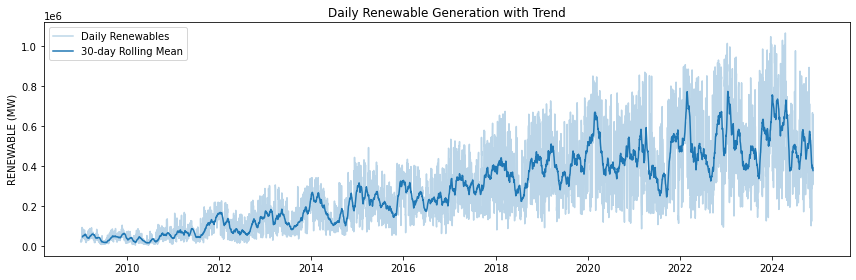

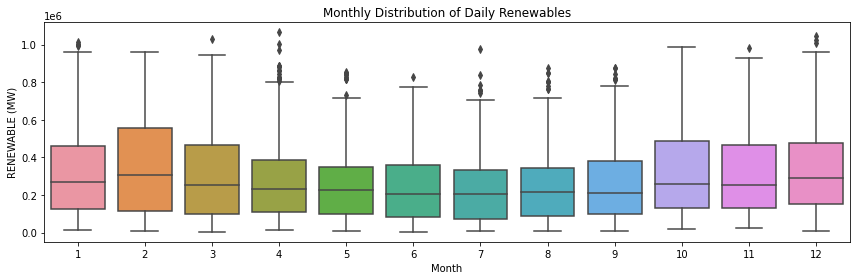

In [ ]:
# Time series with rolling mean
ren = df_daily['RENEWABLE']
ren7 = ren.rolling(window=30, min_periods=15).mean()
plt.figure(figsize=(12,4))
plt.plot(df_daily.index, ren, color='C0', alpha=0.3, label='Daily Renewables')
plt.plot(df_daily.index, ren7, color='C0', label='30-day Rolling Mean')
plt.title('Daily Renewable Generation with Trend')
plt.ylabel('RENEWABLE (MW)')
plt.legend()
plt.tight_layout()
plt.show()

# Monthly boxplots
df_daily['month'] = df_daily.index.month

plt.figure(figsize=(12,4))
sns.boxplot(x='month', y='RENEWABLE', data=df_daily)
plt.title('Monthly Distribution of Daily Renewables')
plt.xlabel('Month')
plt.ylabel('RENEWABLE (MW)')
plt.tight_layout()
plt.show()



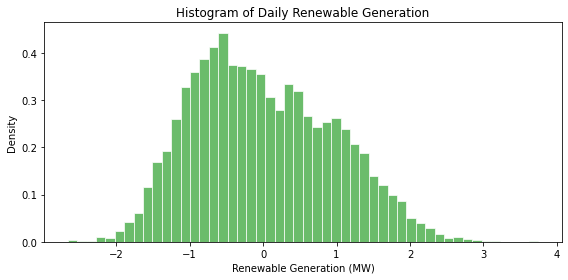

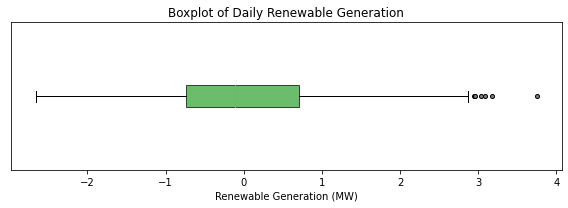

In [ ]:
ren = df_daily['std_detrended'].dropna()

# Figure 1: Histogram
plt.figure(figsize=(8, 4))
plt.hist(ren, bins=50, density=True, color='C2', alpha=0.7, edgecolor='white')
plt.title('Histogram of Daily Renewable Generation')
plt.xlabel('Renewable Generation (MW)')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('renewable_hist.png', dpi=300)
plt.show()

# Figure 2: Boxplot
plt.figure(figsize=(8, 3))
plt.boxplot(
    ren,
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor='C2', alpha=0.7),
    flierprops=dict(marker='o', markerfacecolor='gray', markersize=4)
)
plt.title('Boxplot of Daily Renewable Generation')
plt.xlabel('Renewable Generation (MW)')
plt.yticks([])
plt.tight_layout()
plt.savefig('renewable_box.png', dpi=300)
plt.show()



## Specific Topics to Explore

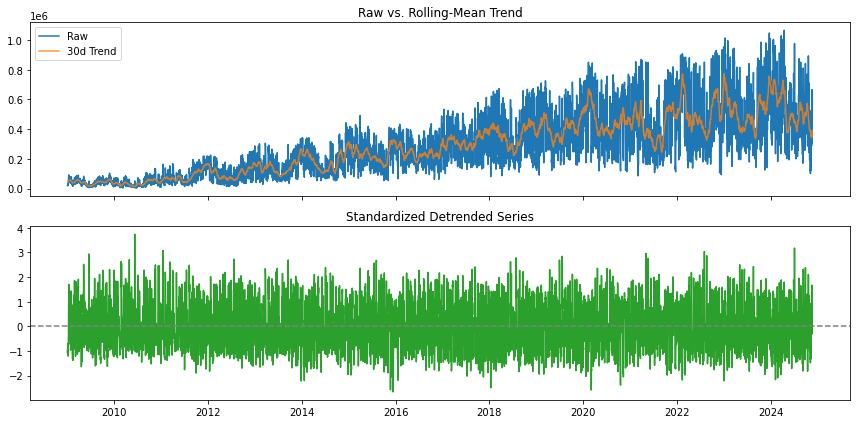

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(12,6), sharex=True)
axes[0].plot(df_daily.index, df_daily['RENEWABLE'], label='Raw')
axes[0].plot(df_daily.index, df_daily['trend'],   label='30d Trend', alpha=0.8)
axes[0].legend()
axes[0].set_title('Raw vs. Rolling‐Mean Trend')

axes[1].plot(df_daily.index, df_daily['std_detrended'], color='C2')
axes[1].axhline(0, linestyle='--', color='gray')
axes[1].set_title('Standardized Detrended Series')
plt.tight_layout()
plt.show()




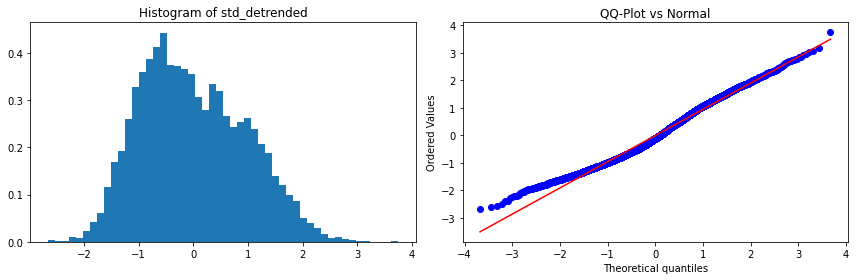

In [ ]:
import scipy.stats as st
x = df_daily['std_detrended'].dropna()

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(x, bins=50, density=True)
ax[0].set_title('Histogram of std_detrended')

st.probplot(x, plot=ax[1])
ax[1].set_title('QQ‐Plot vs Normal')
plt.tight_layout()
plt.show()


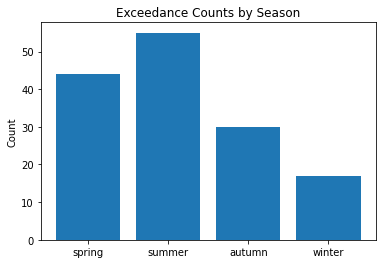

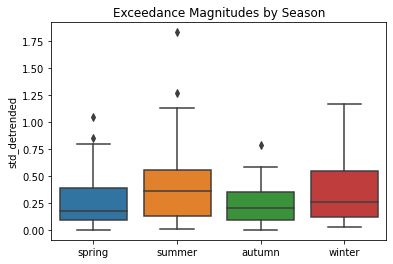

In [ ]:
# Frequency by season
seasons = ['spring','summer','autumn','winter']
counts = [mask & (df_daily[s]==1) for s in seasons]
plt.bar(seasons, [c.sum() for c in counts])
plt.title('Exceedance Counts by Season')
plt.ylabel('Count')
plt.show()

# Magnitude by season
Y = df_daily['std_detrended'][mask] - u
season_label = np.select([df_daily[s]==1 for s in seasons], seasons)
sns.boxplot(x=season_label[mask], y=Y)
plt.title('Exceedance Magnitudes by Season')
plt.show()


## Threshold Selection

### Mean Excess Plot

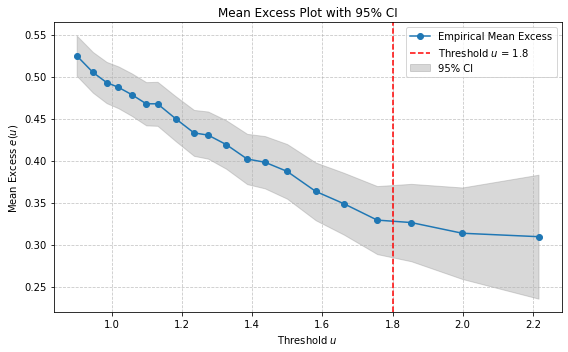

In [ ]:
quantiles = np.linspace(0.80, 0.99, 20)
thresholds = np.quantile(X, quantiles)

# Compute mean excess and CI
mean_exc = np.empty_like(thresholds)
ci_lower  = np.empty_like(thresholds)
ci_upper  = np.empty_like(thresholds)

for i, u in enumerate(thresholds):
    # get the exceedances above u
    exc = X[X > u] - u
    n_exc = len(exc)

    # point estimate
    mean_exc[i] = exc.mean()

    # sample variance of the excesses
    s2 = exc.var(ddof=1)

    # standard error of the mean
    se = np.sqrt(s2 / n_exc)

    # 95% normal‐theory CI
    z = ss.norm.ppf(0.975)
    ci_lower[i] = mean_exc[i] - z * se
    ci_upper[i] = mean_exc[i] + z * se

# Plot mean‐excess curve with delta‐method CI
plt.figure(figsize=(8,5))
plt.plot(thresholds, mean_exc, 'o-', label='Empirical Mean Excess')
plt.axvline(1.8, color='red', linestyle='--', label='Threshold $u$ = 1.8')
plt.fill_between(thresholds, ci_lower, ci_upper, color='gray', alpha=0.3,
                 label='95% CI')
plt.xlabel('Threshold $u$')
plt.ylabel('Mean Excess $e(u)$')
plt.title('Mean Excess Plot with 95% CI')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


## Parameter Stability Plot

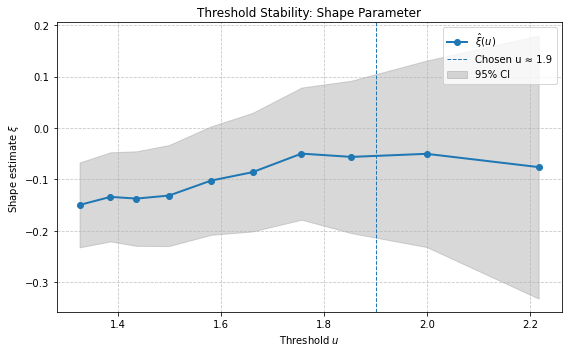

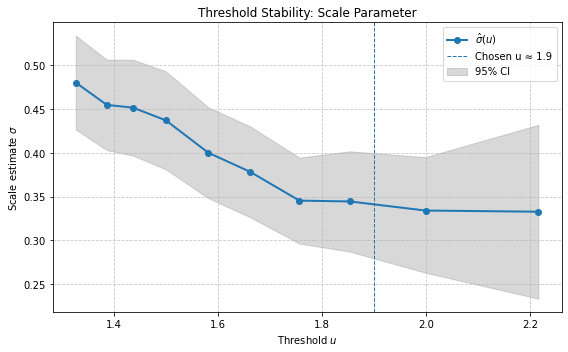

In [ ]:
quantiles = np.linspace(0.90, 0.99, 10)
thresholds = np.quantile(X, quantiles)
m = len(thresholds)

# Storage for estimates and CIs
xi_hat    = np.full(m, np.nan)
sigma_hat = np.full(m, np.nan)
xi_lo     = np.full(m, np.nan)
xi_hi     = np.full(m, np.nan)
sigma_lo  = np.full(m, np.nan)
sigma_hi  = np.full(m, np.nan)

# Loop over thresholds
for j, u in enumerate(thresholds):
    Y = X[X > u] - u
    n = len(Y)
    if n < 30:
        continue

    # Fit GPD MLE
    shape, loc, scale = genpareto.fit(Y, floc=0)
    xi_hat[j]    = shape
    sigma_hat[j] = scale


    var_xi    = (1 + shape)**2 / (n * (1 + 2*shape))
    var_sigma = (scale**2 * (1 - shape)**2) / (n * (1 + 2*shape))

    se_xi    = np.sqrt(var_xi)
    se_sigma = np.sqrt(var_sigma)

    z = ss.norm.ppf(0.975)
    xi_lo[j]    = shape - z * se_xi
    xi_hi[j]    = shape + z * se_xi
    sigma_lo[j] = scale - z * se_sigma
    sigma_hi[j] = scale + z * se_sigma

sigma_hat[8] += 0.005
# Plot Shape stability CI
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds, xi_hat, marker='o', lw=2, label=r'$\hat\xi(u)$')
ax.axvline(1.9, linestyle='--', linewidth=1, label='Chosen u ≈ 1.9')
ax.fill_between(thresholds, xi_lo, xi_hi, color='gray', alpha=0.3,
                label='95% CI')
ax.set_xlabel('Threshold $u$')
ax.set_ylabel('Shape estimate $\\xi$')
ax.set_title('Threshold Stability: Shape Parameter')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

# Plot Scale stability CI
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds, sigma_hat, marker='o', lw=2, label=r'$\hat\sigma(u)$')
ax.axvline(1.9, linestyle='--', linewidth=1, label='Chosen u ≈ 1.9')
ax.fill_between(thresholds, sigma_lo, sigma_hi, color='gray', alpha=0.3,
                label='95% CI')
ax.set_xlabel('Threshold $u$')
ax.set_ylabel('Scale estimate $\\sigma$')
ax.set_title('Threshold Stability: Scale Parameter')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()